# Table 2, region information

In [2]:
import sys
import os
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

In [3]:
in_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-spreadsheets')
source_locations = pandas.read_excel(in_dir/'ssm_pnt_wq_station_info.xlsx',index_col='Unnamed: 0')
source_locations

,type,node_id,layer_distribute,basin,country,NH4[kg/year],NO3NO2[kg/year],N-load
Agate East,River,15634,Surface3,South_Sound,United States,2.125026e+02,4713.218543,4.925721e+03
Agate West,River,15936,Surface3,South_Sound,United States,3.992918e+01,896.648711,9.365779e+02
Anderson east,River,14437,Surface3,South_Sound,United States,6.174089e+01,3384.615894,3.446357e+03
Anderson west,River,14689,Surface3,South_Sound,United States,1.910032e+02,10453.755943,1.064476e+04
Artondale,River,14177,Surface3,South_Sound,United States,2.413960e+02,10868.466526,1.110986e+04
...,...,...,...,...,...,...,...,...
Clover Point,Point Source,3241,Layer 10,Vanc_Island_South,Canada,3.245933e+06,1067.073558,3.247000e+06
Gulf Islands,Point Source,5122,Layer 10,Vanc_Island_South,Canada,1.281677e+03,1419.646956,2.701324e+03
Macaulay,Point Source,3144,Layer 10,Vanc_Island_South,Canada,6.662098e+05,822.994143,6.670328e+05
Saanich,Point Source,3799,Layer 10,Vanc_Island_South,Canada,2.083908e+03,46547.902947,4.863181e+04


In [3]:
[*source_locations]

['type',
 'node_id',
 'layer_distribute',
 'basin',
 'country',
 'NH4[kg/year]',
 'NO3NO2[kg/year]',
 'N-load']

In [4]:
N_loading = source_locations[['N-load','basin']].groupby('basin').sum()

In [5]:
N_sources = source_locations[['N-load','basin']].groupby('basin').count()

## Assume commencement bay and elliot bay are in "Puget_Main"

# Load shapefile

In [6]:
with open('../../etc/SSM_config_whidbey.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
    # get shapefile path    
    shp = ssm['paths']['shapefile']
    
# Define dimension sizes and load shapefile
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')

(-13900000.0, -13580000.0)

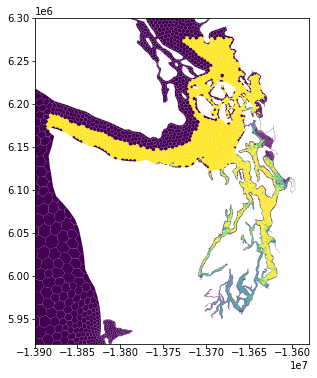

In [33]:
fig_title = f"Map of cell areas"
# plot differences for each run
fig, axs = plt.subplots(1,1, figsize = (8,6))
gdf.plot('km2',ax=axs, vmin=0, vmax=1,legend=False) 
axs.set_ylim(5.92e6, 6.3e6)
axs.set_xlim(-1.39e7,-1.358e7)

In [7]:
AreaVolume=gdf[['km2','volume','Regions']].groupby('Regions').sum()

In [8]:
depth = gdf[['depth','Regions']].groupby('Regions').mean()

In [9]:
DepthAreaVolume = AreaVolume.join(depth).rename(columns={'km2':'Area (km2)', 'volume':'Volume (km3)', 'depth':'Depth (km)'})
DepthAreaVolume

,Area (km2),Volume (km3),Depth (km)
Regions,,,
Hood,289.848286,19.896706,0.066558
Main,635.783572,70.753393,0.093018
Other,182.795790,22.215650,0.120984
SJF_Admiralty,2719.255998,260.005726,0.073423
SOG_Bellingham,1837.149166,153.928370,0.066963
South_Sound,327.142645,13.384382,0.037622
Whidbey,390.823792,23.323780,0.053694


In [10]:
DepthAreaVolume['Nitrogen Loading (kg/year)']=np.zeros(len(DepthAreaVolume))
DepthAreaVolume['Nitrogen Loading (kg/year)'].loc['Hood'] = N_loading.loc['  Hood_Canal'].item()
DepthAreaVolume['Nitrogen Loading (kg/year)'].loc['Main'] = \
  N_loading.loc['  Puget_Main'].item()+\
  N_loading.loc['  Commencement_Bay'].item()+\
  N_loading.loc['  Elliott_Bay'].item()+\
  N_loading.loc['  Sinclair_Dyes'].item()
DepthAreaVolume['Nitrogen Loading (kg/year)'].loc['SJF_Admiralty'] = N_loading.loc['  Admiralty'].item()+N_loading.loc['  SJF'].item()
DepthAreaVolume['Nitrogen Loading (kg/year)'].loc['SOG_Bellingham'] = N_loading.loc['  SOG'].item()
DepthAreaVolume['Nitrogen Loading (kg/year)'].loc['South_Sound'] = N_loading.loc['  South_Sound'].item()
DepthAreaVolume['Nitrogen Loading (kg/year)'].loc['Whidbey'] = N_loading.loc['  Whidbey'].item()

In [11]:
DepthAreaVolume['Number of Sources']=np.zeros(len(DepthAreaVolume))
DepthAreaVolume['Number of Sources'].loc['Hood'] = N_sources.loc['  Hood_Canal'].item()
DepthAreaVolume['Number of Sources'].loc['Main'] = \
  N_sources.loc['  Puget_Main'].item()+\
  N_sources.loc['  Commencement_Bay'].item()+\
  N_sources.loc['  Elliott_Bay'].item()+\
  N_sources.loc['  Sinclair_Dyes'].item()
DepthAreaVolume['Number of Sources'].loc['SJF_Admiralty'] = N_sources.loc['  Admiralty'].item()+N_sources.loc['  SJF'].item()
DepthAreaVolume['Number of Sources'].loc['SOG_Bellingham'] = N_sources.loc['  SOG'].item()
DepthAreaVolume['Number of Sources'].loc['South_Sound'] = N_sources.loc['  South_Sound'].item()
DepthAreaVolume['Number of Sources'].loc['Whidbey'] = N_sources.loc['  Whidbey'].item()

In [12]:
DepthAreaVolume

,Area (km2),Volume (km3),Depth (km),Nitrogen Loading (kg/year),Number of Sources
Regions,,,,,
Hood,289.848286,19.896706,0.066558,3.571981e+05,21.0
Main,635.783572,70.753393,0.093018,1.142570e+07,61.0
Other,182.795790,22.215650,0.120984,0.000000e+00,0.0
SJF_Admiralty,2719.255998,260.005726,0.073423,4.354497e+05,20.0
SOG_Bellingham,1837.149166,153.928370,0.066963,2.920987e+06,29.0
South_Sound,327.142645,13.384382,0.037622,2.661235e+06,84.0
Whidbey,390.823792,23.323780,0.053694,7.601597e+06,27.0


In [13]:
DepthAreaVolume=DepthAreaVolume.sort_values(by='Nitrogen Loading (kg/year)', ascending=False)

In [14]:
# # Add information on river volume input
# flow_f= in_dir/'flow_timeseries.xlsx'
# flow_df = pandas.read_excel(flow_f, sheet_name = "Sheet1")

# river_flow_df={}
# for case in ['whidbey','SOG_NB']:
#     with open(f'../../etc/SSM_config_{case}.yaml','r') as file:
#         ssm = yaml.safe_load(file)

#     # Rivers: create a dataframe with Annual total flow
#     river_flow=[]
#     for river in [*ssm['river_names']]:
#         river_flow.append(flow_df[river][2]) 
#     river_flow_df[case] = pandas.DataFrame({'Annual Total Flow (MG/year)':river_flow}, index=ssm['river_names'])
#     #river_load_df[case] = river_load_df.join(river_flow_df) # Adds new column using index to match rows
  
#DepthAreaVolume['River flow']=np.zeros(len(DepthAreaVolume))
#DepthAreaVolume['River flow'].loc['SOG_Bellingham'] = river_flow_df['SOG_NB'].sum().item()
#DepthAreaVolume['River flow'].loc['Whidbey'] = river_flow_df['whidbey'].sum().item()


In [15]:
DepthAreaVolume

,Area (km2),Volume (km3),Depth (km),Nitrogen Loading (kg/year),Number of Sources
Regions,,,,,
Main,635.783572,70.753393,0.093018,1.142570e+07,61.0
Whidbey,390.823792,23.323780,0.053694,7.601597e+06,27.0
SOG_Bellingham,1837.149166,153.928370,0.066963,2.920987e+06,29.0
South_Sound,327.142645,13.384382,0.037622,2.661235e+06,84.0
SJF_Admiralty,2719.255998,260.005726,0.073423,4.354497e+05,20.0
Hood,289.848286,19.896706,0.066558,3.571981e+05,21.0
Other,182.795790,22.215650,0.120984,0.000000e+00,0.0


In [38]:
DepthAreaVolume['Loading by area']=[DepthAreaVolume['Nitrogen Loading (kg/year)'][region]/(1e6*DepthAreaVolume['Area (km2)'][region]) for region in DepthAreaVolume.index.to_list()]
DepthAreaVolume['Loading by volume']=[DepthAreaVolume['Nitrogen Loading (kg/year)'][region]/(1e9*DepthAreaVolume['Volume (km3)'][region]) for region in DepthAreaVolume.index.to_list()]
DepthAreaVolume

,Area (km2),Volume (km3),Depth (km),Nitrogen Loading (kg/year),Number of Sources,Loading by area,Loading by volume
Regions,,,,,,,
Main,635.783572,70.753393,0.093018,1.142570e+07,61.0,0.017971,0.000161
Whidbey,390.823792,23.323780,0.053694,7.601597e+06,27.0,0.019450,0.000326
SOG_Bellingham,1837.149166,153.928370,0.066963,2.920987e+06,29.0,0.001590,0.000019
South_Sound,327.142645,13.384382,0.037622,2.661235e+06,84.0,0.008135,0.000199
SJF_Admiralty,2719.255998,260.005726,0.073423,4.354497e+05,20.0,0.000160,0.000002
Hood,289.848286,19.896706,0.066558,3.571981e+05,21.0,0.001232,0.000018
Other,182.795790,22.215650,0.120984,0.000000e+00,0.0,0.000000,0.000000


In [41]:
635.783572* 0.093018

59.13931630029601

In [37]:
DepthAreaVolume['Area (km2)']* 1e6

Regions
Main              6.357836e+08
Whidbey           3.908238e+08
SOG_Bellingham    1.837149e+09
South_Sound       3.271426e+08
SJF_Admiralty     2.719256e+09
Hood              2.898483e+08
Other             1.827958e+08
Name: Area (km2), dtype: float64

In [36]:
DepthAreaVolume['Area (km2)']* 1e6*DepthAreaVolume['Depth (km)']*1000

Regions
Main              5.913943e+10
Whidbey           2.098475e+10
SOG_Bellingham    1.230217e+11
South_Sound       1.230762e+10
SJF_Admiralty     1.996546e+11
Hood              1.929174e+10
Other             2.211544e+10
dtype: float64

In [17]:
DepthAreaVolume

,Area (km2),Volume (km3),Depth (km),Nitrogen Loading (kg/year),Number of Sources,Loading by area,Loading by volume
Regions,,,,,,,
Main,635.783572,70.753393,0.093018,1.142570e+07,61.0,17971.048330,161486.211235
Whidbey,390.823792,23.323780,0.053694,7.601597e+06,27.0,19450.189109,325916.160116
SOG_Bellingham,1837.149166,153.928370,0.066963,2.920987e+06,29.0,1589.956544,18976.276631
South_Sound,327.142645,13.384382,0.037622,2.661235e+06,84.0,8134.783771,198831.339614
SJF_Admiralty,2719.255998,260.005726,0.073423,4.354497e+05,20.0,160.135597,1674.769585
Hood,289.848286,19.896706,0.066558,3.571981e+05,21.0,1232.362267,17952.624118
Other,182.795790,22.215650,0.120984,0.000000e+00,0.0,0.000000,0.000000


# Save to file

In [18]:
# make README 
this_file = '=HYPERLINK("https://github.com/UWModeling/KingCounty-Rachael/blob/main/notebooks/reports/Table2_RegionInformation.ipynb")'
run_description = '=HYPERLINK("https://github.com/RachaelDMueller/KingCounty-Rachael/blob/main/docs/supporting/KingCounty_Model_Runs.xlsx","KingCounty_Model_Runs.xlsx (USING ORIGINAL RUN TAGS!!!)")'

created_by = 'Rachael D. Mueller'
created_at = 'Puget Sound Institute'
created_from = 'Model results produced by Su Kyong Yun at the Salish Sea Modeling Center'
created_on = date.today().strftime("%B %d, %Y")
contact = 'Rachael D Mueller (rdmseas@uw.edu)'
header = {
    ' ':[created_by, created_at, created_on, this_file, 
        contact, created_from, 
        run_description]
}
header_df = pandas.DataFrame(header, index=[
    'Created by',
    'Created at',                           
    'Created on',
    'Created with',
    'Contacts',
    'Modeling by',
    'Model Run Overview'])

# Save to output to 
excel_output_path = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/reports')

print('*************************************************************')
print('Writing spreadsheet to: ',excel_output_path)
print('*************************************************************')
if os.path.exists(excel_output_path)==False:
    print(f'creating: {excel_output_path}')
    os.umask(0) #clears permissions
    os.makedirs(excel_output_path, mode=0o777,exist_ok=True)
with pandas.ExcelWriter(
    excel_output_path/'Table2_RegionalOverview.xlsx', mode='w') as writer:  
    DepthAreaVolume.to_excel(writer, sheet_name=f'Summary')
    header_df.to_excel(writer, sheet_name='README')

*************************************************************
Writing spreadsheet to:  /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/reports
*************************************************************
